# Setup Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import seaborn as sns
print("All libraries imported successfully!")
#! pip install gradio_client


All libraries imported successfully!


# Step 0: Define the Question

Can we predict cancer types from gene expression data?

We need:

- gene expression data
- subtype labels

# Step 1: Data Collection 

We will use a partially preprocessed dataset published by Pölönen et al. (2024) in their paper "The genomic basis of childhood T-lineage acute lymphoblastic leukaemia":
- 1335 samples with RNA-seq data
- subtype labeling established by expert review of gene expression profiles and genetic alterations in the original paper

# Setup Data

In [2]:
path = "gene_expression_names.tsv"
if os.path.exists(path):
    print("File already exists")
else:
  !wget "https://raw.githubusercontent.com/UKWgenommedizin/clinTALL/refs/heads/main/data/user/gene_expression_names.tsv"

path = "labels.tsv"
if os.path.exists(path):
    print("File already exists")
else:
  !wget "https://raw.githubusercontent.com/UKWgenommedizin/clinTALL/refs/heads/main/data/user/reference/labels.tsv"

File already exists
File already exists


# Load Data

## Inspect gene expression data

In [3]:
expression = pd.read_csv('gene_expression_names.tsv', sep='\t', index_col=0)
expression.head()

,VEGFC,ARHGAP5,REG4,TFDP2,ZNF423,MEX3B,JUP,C17orf51,MORC4,TRAM2-AS1,...,BMPR1A,ANK1,AUTS2,LRRN2,IGLC1,ZNF608,ZNF677,RN7SK,MT-CO1,RN7SL1
PAUCKE,1,1395,0,8005,0,766,2450,214,95,28,...,19,208,15,742,1,0,45,233010,1555496,1011151
PARLHD,1,5446,5,29740,1585,1016,156,396,276,61,...,19,575,201,68,33,19,13,1012599,285980,843739
PARMJA,0,4382,0,10478,987,1794,2037,458,343,54,...,49,1703,261,590,24,13,593,1552860,173047,911821
PARVRF,75,1836,0,1925,1,677,227,14,3,30,...,128,251,1104,8,20,2,60,111931,1957782,2249695
PARYMD,22,3622,22,4804,2,717,701,8,1,44,...,18,1359,914,52,132,24,5,710822,958827,120390


In [ ]:
expression.iloc[0,:]

## Understanding gene expression data

- gene expression count matrix derived from high-throughput RNA sequencing 
- each row corresponds to a biological sample (e.g., PAUCKE, PARLHD, PARMJA)
- each column corresponds to a gene or transcript, identified by gene symbols (e.g., VEGFC, ARHGAP5, BMPR1A, MT-CO1).

The numeric values in the matrix represent raw read counts, indicating how many sequencing reads were mapped to each gene in each sample. Higher counts reflect higher expression levels, whereas zeros indicate genes that were not detected in a given sample.

## Inspect labels

In [4]:
labels = pd.read_csv('labels.tsv', sep='\t', index_col=0)
print(labels.head(5))
labels.value_counts()

       Reviewed.subtype
PAUCKE     LMO2 γδ-like
PARLHD     TAL1 DP-like
PARMJA     TAL1 αβ-like
PARVRF             TLX3
PARYMD             TLX3


Reviewed.subtype
TAL1 DP-like        300
ETP-like            240
TAL1 αβ-like        223
TLX3                220
NKX2-1               77
TLX1                 74
TME-enriched         42
KMT2A                39
MLLT10               32
HOXA9 TCR            22
BCL11B               18
SPI1                 11
LMO2 γδ-like         10
STAG2/LMO2            8
NKX2-5                8
NUP98                 6
NUP214                5
Name: count, dtype: int64

- each label is the name of a T-All subtype
- each sample has exactly one label/subtype

## Additional Questions: 
Cohort representativeness - Who or what does the dataset actually represent?

Label reliability
- Gold standard vs proxy
- Objective vs subjective
- Stable vs evolving over time

# Step 1: Data Preprocessing

## First we need to check if our data is consistent:
- are the samples in the expression data and the labels are the same and in the same order?
- are there are any missing values in the expression data or the labels.
- are there are any duplicate samples in the expression data or the labels.
- are there are any outliers/bad samples in the expression data.
- are the samples on the same scale/comparable

In [5]:
if all(expression.index == labels.index):
    print("Indices match!")
else:
    print("Indices do not match. Please check the data.")
print(expression.shape)
expression.head()

Indices match!
(1335, 1000)


,VEGFC,ARHGAP5,REG4,TFDP2,ZNF423,MEX3B,JUP,C17orf51,MORC4,TRAM2-AS1,...,BMPR1A,ANK1,AUTS2,LRRN2,IGLC1,ZNF608,ZNF677,RN7SK,MT-CO1,RN7SL1
PAUCKE,1,1395,0,8005,0,766,2450,214,95,28,...,19,208,15,742,1,0,45,233010,1555496,1011151
PARLHD,1,5446,5,29740,1585,1016,156,396,276,61,...,19,575,201,68,33,19,13,1012599,285980,843739
PARMJA,0,4382,0,10478,987,1794,2037,458,343,54,...,49,1703,261,590,24,13,593,1552860,173047,911821
PARVRF,75,1836,0,1925,1,677,227,14,3,30,...,128,251,1104,8,20,2,60,111931,1957782,2249695
PARYMD,22,3622,22,4804,2,717,701,8,1,44,...,18,1359,914,52,132,24,5,710822,958827,120390


## Do we have duplicates in our dataset?

In [6]:
print('Number of unique samples in expression data:', expression.index.nunique())
print('Number of genes in expression data:', expression.columns.nunique())

Number of unique samples in expression data: 1335
Number of genes in expression data: 1000


! This is only a part of a full gene expression dataset - otherwise these examples would take too much time

## Are there values missing in our data?

In [7]:
print("Number of missing values in expression data:", expression.isna().sum().sum())
print("Number of missing values in labels data:", labels.isna().sum().sum())

Number of missing values in expression data: 0
Number of missing values in labels data: 0


## Quality control

How many reads were counted per sample:
- very low number suggests bad sample

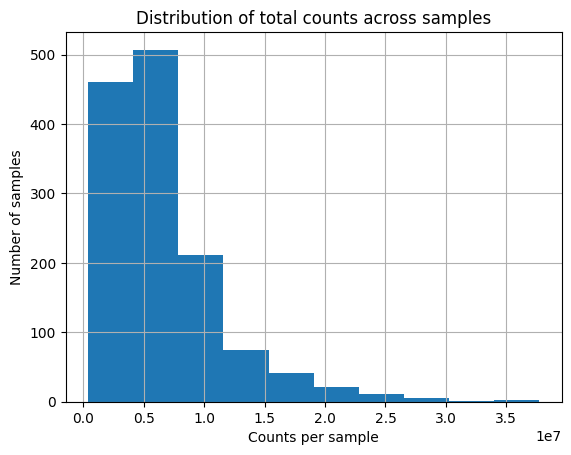

Min: 415164
Max: 37709583


In [8]:
expression.sum(axis=1).hist()
plt.xlabel('Counts per sample')
plt.ylabel('Number of samples')
plt.title('Distribution of total counts across samples')
plt.show()
print("Min:", expression.sum(axis=1).min())
print("Max:", expression.sum(axis=1).max())

We don't have samples we need to exclude


## Normalization
Number of reads varies widely between samples, we need to address this scale difference:

--> Compute counts per million (counts)

In [9]:
expression_cpm = expression.div(expression.sum(axis=1), axis=0) * 1e6
expression_cpm.sum(axis=1).head()


PAUCKE    1000000.0
PARLHD    1000000.0
PARMJA    1000000.0
PARVRF    1000000.0
PARYMD    1000000.0
dtype: float64

All our samples are now normalized to 1M counts

In [10]:
expression_cpm.head()

,VEGFC,ARHGAP5,REG4,TFDP2,ZNF423,MEX3B,JUP,C17orf51,MORC4,TRAM2-AS1,...,BMPR1A,ANK1,AUTS2,LRRN2,IGLC1,ZNF608,ZNF677,RN7SK,MT-CO1,RN7SL1
PAUCKE,0.231988,323.623244,0.000000,1857.063849,0.000000,177.702799,568.370572,49.645430,22.038859,6.495664,...,4.407772,48.253502,3.479820,172.135088,0.231988,0.000000,10.439459,54055.521221,360856.388300,234574.886651
PARLHD,0.253194,1378.896852,1.265972,7530.002274,401.313168,257.245538,39.498331,100.264993,69.881662,15.444860,...,4.810694,145.586796,50.892080,17.217221,8.355416,4.810694,3.291528,256384.424086,72408.542375,213630.013060
PARMJA,0.000000,991.823006,0.000000,2371.593211,223.397834,406.054421,461.055103,103.663838,77.634708,12.222374,...,11.090673,385.457457,59.074807,133.540752,5.432166,2.942423,134.219772,351474.731261,39167.502428,206381.799346
PARVRF,13.420126,328.524693,0.000000,344.449910,0.178935,121.139007,40.618249,2.505090,0.536805,5.368051,...,22.903682,44.912690,197.544260,1.431480,3.578700,0.357870,10.736101,20028.375515,350315.757680,402549.215629
PARYMD,8.530296,1404.396902,8.530296,1862.706438,0.775481,278.010099,271.806248,3.101926,0.387741,17.060592,...,6.979333,526.939644,354.395022,20.162518,51.181776,9.305777,1.938704,275614.636902,371776.275153,46680.105760


## Check data via visualization

This often helps to catch outliers or missing preprocessing steps!

## PCA - Principal Component Analysis
- A PCA is a linear dimensionality reduction technique:
- that transforms the data into a new coordinate system, 
- where the greatest variance by any projection of the data comes to lie on the first coordinate (called the first principal component), 
- the second greatest variance on the second coordinate, and so on. 
- PCA is often used for visualization and to reduce the dimensionality of data while retaining as much variance as possible. 

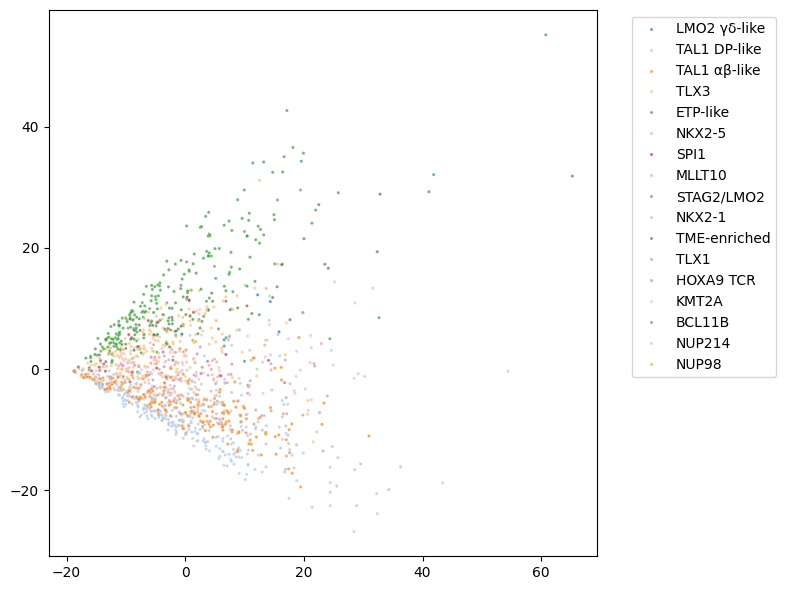

In [11]:
pca = PCA(n_components=2)
std_scaler = StandardScaler()
expression_pca = pca.fit_transform(std_scaler.fit_transform(expression_cpm))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=expression_pca[:, 0], y=expression_pca[:, 1], s=5, alpha=0.7, hue=labels['Reviewed.subtype'], palette='tab20', legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In our case we already see some class separation in the PCA plot, otherwise it seems unremarkable

## UMAP - Uniform Manifold Approximation and Projection for Dimension Reduction
- UMAP is a non-linear dimensionality reduction technique 
- that preserves local and global structure in the data, 
- making it ideal for visualizing complex datasets like gene expression profiles. 
- It can capture non-linear relationships between samples, which PCA may miss, 
- and often reveals clusters or patterns that are not apparent in linear projections.

C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


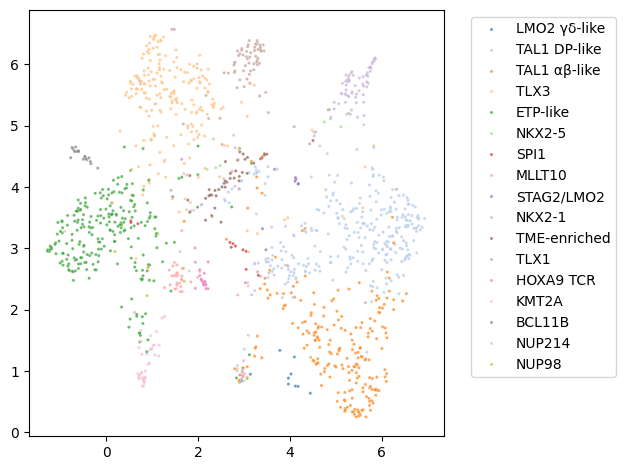

In [12]:
import seaborn as sns
from umap import UMAP
labels_formatted = labels['Reviewed.subtype'].str.replace('γ', r'$\gamma$', regex=False)\
                         .str.replace('δ', r'$\delta$', regex=False)\
                         .str.replace('α', r'$\alpha$', regex=False)\
                         .str.replace('β', r'$\beta$', regex=False)\
                         .str.replace('&', r'\&', regex=False)
umap = UMAP()
scaler = StandardScaler()
umap = umap.fit_transform(scaler.fit_transform(expression_cpm))
sns.scatterplot(x=umap[:, 0], y=umap[:, 1], s=5, alpha=0.7, hue=labels['Reviewed.subtype'], palette='tab20', legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

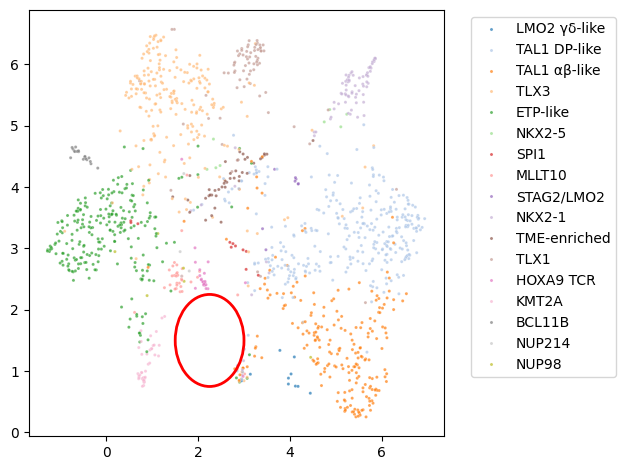

In [13]:
from matplotlib.patches import Circle

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], s=5, alpha=0.7, hue=labels['Reviewed.subtype'], palette='tab20', legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()
ax.add_patch(Circle((2.25, 1.5), 0.75, edgecolor='red', facecolor='none', lw=2))
plt.tight_layout()
plt.show()

There is a cluster of samples in the upper right corner that seems to be separated from the rest. 

It could be interesting to investigate the characteristics of these samples further,
to understand why they are clustering together and how they differ from the other samples.

Skip this at this point (Cluster does not seem to correlate with any data we checked for)

# Step 3: Data split

- We split our data into portions for training (70%) and testing/validation (30%)
- To ensure reproducibility, we set a random state
- We stratify the split to maintain class distribution in both sets

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(expression_cpm), labels.values.ravel(), test_size=0.3, random_state=42
)

train = pd.Series(y_train).value_counts()/len(y_train)
test = pd.Series(y_test).value_counts()/len(y_test)
total = pd.concat([train, test], axis=1, keys=['Train', 'Test'])
total

,Train,Test
TAL1 DP-like,0.232334,0.206983
ETP-like,0.179872,0.179551
TAL1 αβ-like,0.178801,0.139651
TLX3,0.162741,0.169576
TLX1,0.057816,0.049875
NKX2-1,0.054604,0.064838
TME-enriched,0.028908,0.037406
MLLT10,0.023555,0.024938
KMT2A,0.020343,0.049875
HOXA9 TCR,0.014989,0.019950


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(expression_cpm), labels.values.ravel(), test_size=0.3, random_state=42, stratify=labels.values.ravel()
)

train=pd.Series(y_train).value_counts()/len(y_train)
test=pd.Series(y_test).value_counts()/len(y_test)
total=pd.concat([train, test], axis=1, keys=['Train', 'Test'])
total

,Train,Test
TAL1 DP-like,0.224839,0.224439
ETP-like,0.179872,0.179551
TAL1 αβ-like,0.167024,0.167082
TLX3,0.164882,0.164589
NKX2-1,0.057816,0.057357
TLX1,0.055675,0.054863
TME-enriched,0.031049,0.032419
KMT2A,0.028908,0.029925
MLLT10,0.023555,0.024938
HOXA9 TCR,0.016060,0.017456


For thorough testing typically some form of bootstrapping of cross-validation is used.

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
    print(f"Fold {i+1}")
    print("Train indices:", train_index)
    print("Validation indices:", val_index)
    break

Fold 1
Train indices: [  1   2   3   4   5   6   7   9  10  11  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  30  31  32  33  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  55  58  59  60  61
  62  63  64  65  66  67  68  69  70  72  73  74  75  76  77  79  81  82
  83  85  87  88  89  90  91  94  95  96  98  99 101 103 104 105 106 108
 109 113 114 116 117 118 119 120 121 122 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 145 146 147 149 150 151 152 153
 154 155 156 157 158 159 161 162 165 166 167 168 169 170 171 172 174 175
 176 177 178 179 180 181 182 183 184 186 189 193 194 195 196 197 198 200
 202 203 204 205 206 207 208 209 210 211 213 214 216 217 218 219 220 221
 222 225 226 227 228 229 230 232 233 234 235 236 237 238 239 240 241 242
 245 246 247 248 249 250 251 252 253 254 255 257 258 259 260 261 262 263
 264 265 266 267 271 272 273 274 275 277 278 279 280 281 283 284 285 286
 288 290 291 292 293 294 295 

C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


# Step 4: Choose a machine learning model
We will use logistic regression as an example

Why?
- probabilistic model, interpretable, efficient for high-dimensional data, and can be regularized to prevent overfitting.

In [17]:
model = LogisticRegression(random_state=0, max_iter=500)

# Step 5 & 6: Training, Validation & Tuning

For this example we ignore the tuning step (6)

First we fit our model, then check if it did learn. (Can make accurate predictions)

Accuracy : Number of True Predictions/ Total Number of Samples

In [18]:
#Step 5 & 6: Training, Validation & Tuning
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_on_train = accuracy_score(y_train, model.predict(X_train))
print(f"Accuracy on training set: {accuracy_on_train}")
print(f"Accuracy: {accuracy}")

Accuracy on training set: 1.0
Accuracy: 0.9102244389027432


## How is the training process looking like?
We can track loss and accuracy over the course of training

C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\stoib\

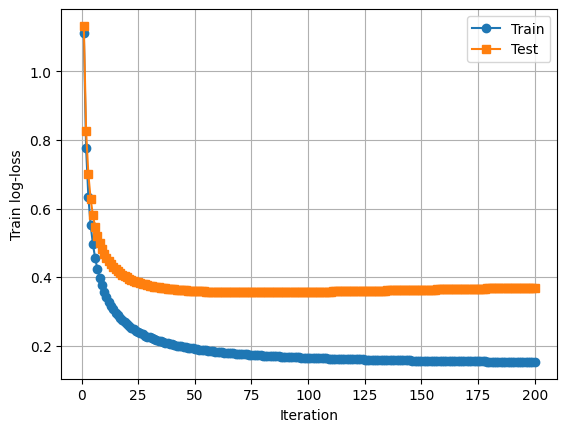

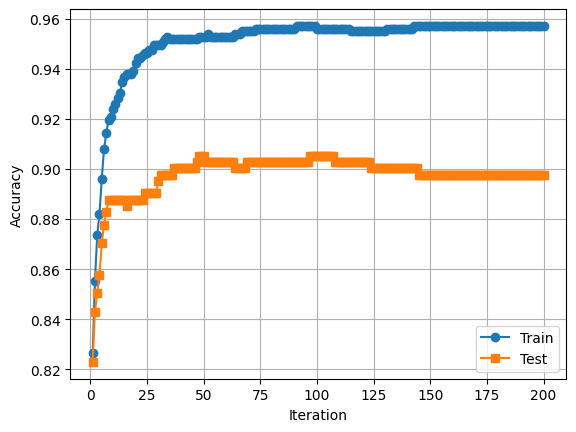

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

model = LogisticRegression(solver='saga', max_iter=1, warm_start=True, random_state=27)  # one iteration per fit
n_iters = 200  # total iterations to track

iters = []
losses = []
losses_test = []
accuracies = []
accuracies_test = []

# Training loop - we call fit multiple times to simulate iterative training and track metrics
for i in range(n_iters):
    model.fit(X_train, y_train)               # continues from previous state due to warm_start=True
    iters.append(i + 1)
    losses.append(log_loss(y_train, model.predict_proba(X_train)))
    losses_test.append(log_loss(y_test, model.predict_proba(X_test)))
    accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    accuracies_test.append(accuracy_score(y_test, model.predict(X_test)))

# Plotting the results
# Loss
plt.plot(iters, losses, marker='o', label='Train')
plt.plot(iters, losses_test, marker='s', label='Test')
plt.xlabel('Iteration')
plt.ylabel('Train log-loss')
plt.grid()
plt.legend()
plt.show()
# Accuracy
plt.plot(iters, accuracies, marker='o', label='Train')
plt.plot(iters, accuracies_test, marker='s', label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')  
plt.grid()
plt.legend()
plt.show()


# Step 7: Testing

For thoroughness we now will test the efficacy of the model via cross-validation
- Every sample will be used as test at least once this way
- We do 5-Fold cross-validation, as the lowest number of samples in one subtype is 5

In [20]:
model = LogisticRegression(random_state=0, max_iter=500)
cv_scores = cross_val_score(model, expression_cpm, labels.values.ravel(), cv=cv, scoring='accuracy')

C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/mod

In [21]:
print(f"Cross-validation score mean: {cv_scores.mean():.4f}")

Cross-validation score mean: 0.8240


With this setup we seem to run into convergence warnings, our model takes longer to learn:
- We can speed this up in our case by scaling the inputs
- This helps stabilizing the training process 

In [22]:
cv_scores = cross_val_score(model, StandardScaler().fit_transform(expression_cpm), labels.values.ravel(), cv=cv)
print(f"Cross-validation score mean: {cv_scores.mean():.4f}")

Cross-validation score mean: 0.9124


If we do it like this, we use information from our training samples to transfrom test samples before we separate them:
- This will overestimate how good our classifier is

Instead we should do this after splitting (or as part of the model):

In [ ]:
from sklearn.pipeline import Pipeline

model = LogisticRegression(random_state=0, max_iter=500)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', model)
])

# other options for logistic regression can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# other models can be used as well, find examples at: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning


cv_scores = cross_val_score(pipeline, expression_cpm, labels.values.ravel(), cv=cv)
print(f"Cross-validation score mean with pipeline: {cv_scores.mean():.4f}")

Cross-validation score mean with pipeline: 0.9056


To inspect the predictions of our model in more detail we can use the confusion matrix

- Accuracy is a global metric
- Often we want to know how we perform for specific classes
    - Do specific classes perform especially bad?
    - Are some classses confused often?

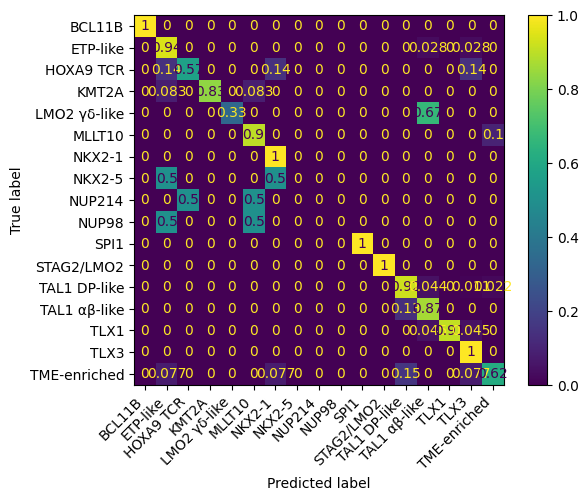

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(expression_cpm), labels.values.ravel(), test_size=0.3, random_state=42, stratify=labels.values.ravel()
)
pipeline.fit(X_train, y_train)

cfm = confusion_matrix(y_test, pipeline.predict(X_test), normalize='true')
disp=ConfusionMatrixDisplay(cfm, display_labels=pipeline.named_steps['classifier'].classes_)
disp.plot()
#Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.show()

Another nice way of checking performance in sklearn is the classification report:

In [25]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=pipeline.named_steps['classifier'].classes_))

# Precision, Recall, F1-score definition:
# - Precision: TP / (TP + FP) - How many of the predicted positives are actually positive?
# - Recall: TP / (TP + FN) - How many of the actual positives were correctly identified?
# - F1-score: 2 * (Precision * Recall) / (Precision + Recall) - Harmonic mean of Precision and Recall, balances the two metrics


              precision    recall  f1-score   support

      BCL11B       1.00      1.00      1.00         5
    ETP-like       0.93      0.94      0.94        72
   HOXA9 TCR       0.80      0.57      0.67         7
       KMT2A       1.00      0.83      0.91        12
LMO2 γδ-like       1.00      0.33      0.50         3
      MLLT10       0.75      0.90      0.82        10
      NKX2-1       0.88      1.00      0.94        23
      NKX2-5       0.00      0.00      0.00         2
      NUP214       0.00      0.00      0.00         2
       NUP98       0.00      0.00      0.00         2
        SPI1       1.00      1.00      1.00         3
  STAG2/LMO2       1.00      1.00      1.00         2
TAL1 DP-like       0.88      0.92      0.90        90
TAL1 αβ-like       0.87      0.87      0.87        67
        TLX1       1.00      0.91      0.95        22
        TLX3       0.92      1.00      0.96        66
TME-enriched       0.73      0.62      0.67        13

    accuracy              

C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\stoib\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

# Step 8: Interpretation

Model interpretation in context of machine learning typically means:
- How important are specific features, or groups of features, for our prediction
- In which direction is the influence

We can interpred our model by looking at it's coefficients
- This is possible with all linear models (which just linearly combine inputs)
    - Feature coefficent == Importance in this case
- For other models it's more complicated and typically computationaly expensive

In [26]:
importance_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, columns=expression_cpm.columns, index=pipeline.named_steps['classifier'].classes_)
importance_df

,VEGFC,ARHGAP5,REG4,TFDP2,ZNF423,MEX3B,JUP,C17orf51,MORC4,TRAM2-AS1,...,BMPR1A,ANK1,AUTS2,LRRN2,IGLC1,ZNF608,ZNF677,RN7SK,MT-CO1,RN7SL1
BCL11B,-0.011575,0.036309,-0.010969,-0.000315,-0.006719,0.023468,0.070951,-0.000628,-0.010711,0.007676,...,-0.004152,-0.013480,0.011495,-0.003993,-0.004154,-0.018107,-0.011134,0.021946,-0.008126,-0.032831
ETP-like,-0.025649,-0.036564,-0.095479,-0.041829,-0.045026,0.010876,0.111690,-0.071922,0.024305,0.121292,...,-0.017516,0.068742,0.085171,0.022325,0.027105,0.013574,-0.042093,0.013058,-0.132131,0.157796
HOXA9 TCR,-0.013639,0.006910,0.005588,0.011652,-0.011317,-0.010730,-0.019662,0.016464,0.076739,-0.010079,...,-0.020573,-0.003492,0.002610,-0.024774,0.018098,-0.005147,-0.031229,0.067641,-0.031700,-0.089890
KMT2A,-0.009565,-0.021694,0.060046,-0.002771,-0.000657,0.007580,0.010539,-0.012300,-0.001932,0.002600,...,-0.018671,-0.021257,-0.009541,0.033215,-0.012131,0.016835,-0.012127,0.043379,-0.051898,-0.003854
LMO2 γδ-like,-0.014808,-0.010657,-0.004899,0.000088,0.010373,0.011858,0.014504,0.002908,-0.007241,-0.002627,...,-0.016221,-0.014988,-0.017535,0.010363,-0.008499,-0.019917,0.047138,-0.064444,0.168413,-0.078650
MLLT10,-0.034525,0.007863,0.043330,0.048452,0.005774,-0.009895,-0.018088,0.083386,-0.045503,0.017806,...,-0.025028,0.007464,0.031016,0.062975,-0.019445,0.111684,-0.027540,-0.018853,-0.109809,0.096101
NKX2-1,-0.050996,-0.043304,0.018908,0.046782,0.094588,0.010764,-0.003450,-0.022025,-0.037711,-0.005700,...,-0.050593,0.020284,-0.025315,-0.050194,0.021034,0.023148,-0.045458,-0.154055,0.146137,0.005336
NKX2-5,-0.010050,0.036770,-0.012969,0.007997,0.019704,-0.004048,-0.013654,-0.020620,-0.018993,0.008438,...,0.026817,-0.018603,-0.022589,0.008158,-0.013256,-0.009172,-0.030630,0.035909,-0.028648,-0.027517
NUP214,-0.008045,0.029168,-0.024861,0.007516,0.013657,0.000211,-0.014619,-0.025381,0.019736,0.011860,...,0.002092,0.005580,-0.014122,-0.023664,-0.009272,0.060011,0.005185,0.165533,-0.064619,-0.114108
NUP98,0.014423,0.002555,0.003542,-0.002611,-0.005994,0.021984,0.007343,-0.007303,0.024297,0.013965,...,-0.003502,-0.014945,-0.001927,0.004622,-0.004932,0.005240,0.051242,0.026097,-0.018728,-0.020183


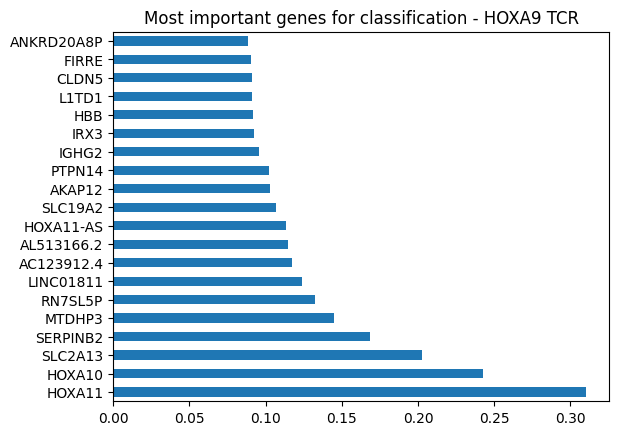

In [ ]:
# Get the importance for the class of interest, to change class change number, e.g. for class 0, 1, 2, 3, 4
n = 2
importance = pd.Series(
    pipeline.named_steps['classifier'].coef_[n],
    index=expression_cpm.columns
).sort_values(ascending=False)

importance.head(20).plot(kind="barh")
plt.title(f"Most important genes for classification - {pipeline.named_steps['classifier'].classes_[n]}")
plt.show()

Text(0, 0.5, 'Number of genes')

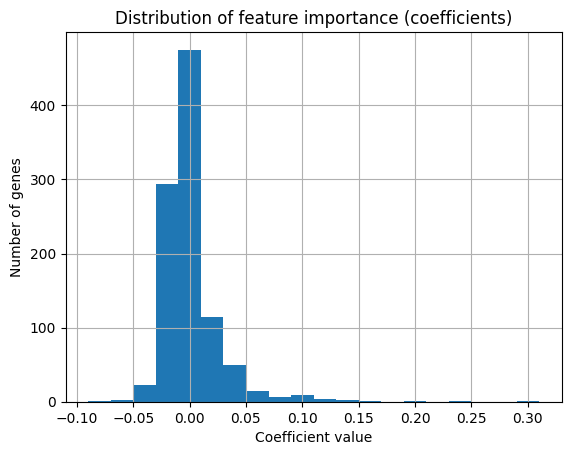

In [28]:
importance.hist(bins=20)
plt.title("Distribution of feature importance (coefficients)")
plt.xlabel('Coefficient value')
plt.ylabel('Number of genes')

In [75]:
importance.to_csv('important_genes.tsv', sep='\t', header=False)
importance[(importance > 0.025) | (importance < -0.025)].index.to_series().to_csv('important_genes_names.tsv', sep='\t', header=False, index=False)

Now we saved a file with a list of all genes and their coefficents, as well as one with the most important ones for the class we specified above.

With those lists we could do a gene set enrichment analysis
 - https://biit.cs.ut.ee/gprofiler/gost
 - https://www.webgestalt.org/

# clinTALL

First we prepare a dataset to generate predictions:

In [31]:
expression.to_csv('expression_sample.tsv', sep='\t')#.sample(n=5)

In [ ]:
from gradio_client import Client, handle_file

client = Client("http://ec2-23-20-191-10.compute-1.amazonaws.com/")
result = client.predict(
	file_obj=handle_file('expression_sample.tsv'),
	api_name="/predict"
)
print(result)

Fallback option if using the server fails - download precomputed predictions

In [36]:
!wget "https://raw.githubusercontent.com/lstoiber/ML-Course-19.02.2026/refs/heads/main/eta.tsv"
!wget "https://raw.githubusercontent.com/lstoiber/ML-Course-19.02.2026/refs/heads/main/probs.tsv"

--2026-02-18 16:48:37--  https://raw.githubusercontent.com/lstoiber/ML-Course-19.02.2026/refs/heads/main/eta.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80389 (79K) [text/plain]
Saving to: 'eta.tsv.4'

     0K .......... .......... .......... .......... .......... 63% 1,95M 0s
    50K .......... .......... ........                        100% 7,93M=0,03s

2026-02-18 16:48:37 (2,69 MB/s) - 'eta.tsv.4' saved [80389/80389]

--2026-02-18 16:48:37--  https://raw.githubusercontent.com/lstoiber/ML-Course-19.02.2026/refs/heads/main/probs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|26

In case we needed to download the precomputed files we need to change the first arguments of the following cells to read them

## Subtype prediction results

In [37]:
#probs = pd.read_csv(result[0][1], sep='\t', index_col=0) # change to probs.tsv
probs = pd.read_csv('probs.tsv', sep='\t', index_col=0)
probs.head()

,prob_BCL11B,prob_ETP-like,prob_HOXA9 TCR,prob_KMT2A,prob_LMO2 γδ-like,prob_MLLT10,prob_NKX2-1,prob_NKX2-5,prob_NUP214,prob_NUP98,prob_SPI1,prob_STAG2/LMO2,prob_TAL1 DP-like,prob_TAL1 αβ-like,prob_TLX1,prob_TLX3,prob_TME-enriched
PAUCKE,4.704473e-06,1.869131e-04,5.020068e-12,2.548832e-07,9.987585e-01,2.179441e-06,5.969334e-07,4.437307e-05,6.170150e-08,1.499722e-05,1.518339e-06,1.318732e-04,1.771433e-06,8.512489e-04,2.075304e-09,6.547288e-07,3.818551e-07
PARLHD,2.143832e-13,8.123934e-10,1.490529e-08,9.649486e-07,8.766595e-09,7.706031e-06,5.922741e-04,1.725591e-05,5.738776e-08,7.463683e-09,5.735019e-09,2.211902e-06,9.971130e-01,2.238243e-03,2.443000e-05,3.481833e-06,3.137336e-07
PARMJA,1.772518e-11,9.563377e-10,1.054904e-12,7.430928e-07,2.793210e-05,6.108539e-07,1.876486e-08,2.861914e-07,2.524776e-09,1.015377e-08,1.771220e-10,8.175531e-07,8.362521e-04,9.991331e-01,6.520072e-09,1.245350e-07,2.497087e-09
PARVRF,2.901370e-06,5.947299e-04,4.070452e-04,2.286717e-06,7.708022e-08,9.132762e-05,2.393866e-06,6.006236e-05,1.566562e-05,1.494806e-05,1.515503e-06,3.176741e-06,1.201786e-06,7.124862e-07,4.040696e-04,9.983752e-01,2.267770e-05
PARYMD,1.741841e-06,3.409383e-03,5.443489e-05,2.319220e-06,4.562987e-08,1.192078e-04,2.742818e-07,2.354879e-04,3.406144e-05,2.275745e-05,7.596112e-08,4.980377e-06,1.017808e-07,1.267425e-07,4.075193e-05,9.960192e-01,5.495411e-05


In [64]:
probs.sum(axis=1).head()

PAUCKE    1.0
PARLHD    1.0
PARMJA    1.0
PARVRF    1.0
PARYMD    1.0
dtype: float64

The model output in this case is class probabilities, so we need to select the coloum with the highest value for each sample to get the predicted class.

In [71]:
preds = probs.idxmax(axis=1)
preds.head()

PAUCKE    prob_LMO2 γδ-like
PARLHD    prob_TAL1 DP-like
PARMJA    prob_TAL1 αβ-like
PARVRF            prob_TLX3
PARYMD            prob_TLX3
dtype: object

This still has the 'prob_' prefix

In [72]:
preds = [i.split('_')[1] for i in preds]
preds[:5]

['LMO2 γδ-like', 'TAL1 DP-like', 'TAL1 αβ-like', 'TLX3', 'TLX3']

Now that the result is formatted correctly, which mean the same way as our labels, we can start inspecting them:

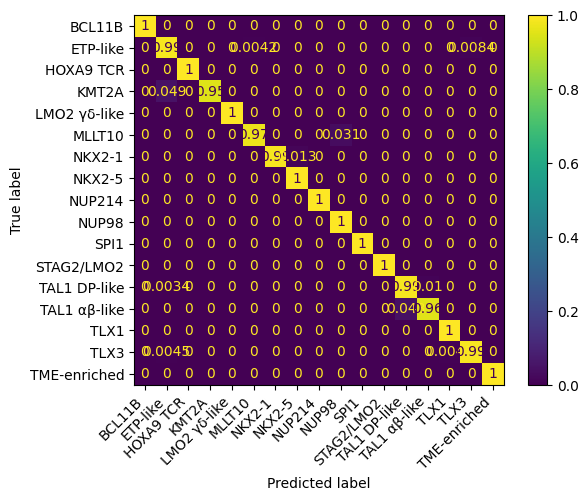

In [73]:
confusion_m = confusion_matrix(preds, labels.values.ravel(), normalize='true')
ConfusionMatrixDisplay(confusion_m, display_labels=pipeline.named_steps['classifier'].classes_).plot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [40]:
print(classification_report(labels.values.ravel(), [i.split('_', 1)[1] for i in probs.idxmax(axis=1) if i.startswith('prob_')], target_names=pipeline.named_steps['classifier'].classes_))


              precision    recall  f1-score   support

      BCL11B       1.00      1.00      1.00        18
    ETP-like       0.99      0.98      0.99       240
   HOXA9 TCR       1.00      1.00      1.00        22
       KMT2A       0.95      1.00      0.97        39
LMO2 γδ-like       1.00      1.00      1.00        10
      MLLT10       0.97      0.97      0.97        32
      NKX2-1       0.99      1.00      0.99        77
      NKX2-5       1.00      0.88      0.93         8
      NUP214       1.00      1.00      1.00         5
       NUP98       1.00      0.83      0.91         6
        SPI1       1.00      1.00      1.00        11
  STAG2/LMO2       1.00      1.00      1.00         8
TAL1 DP-like       0.99      0.97      0.98       300
TAL1 αβ-like       0.96      0.99      0.97       223
        TLX1       1.00      0.99      0.99        74
        TLX3       0.99      0.99      0.99       220
TME-enriched       1.00      1.00      1.00        42

    accuracy              

We could also do a visualization:
- Plot the umap from before again
- Color samples by predicted subtype
- Size of sample inverse proportional to probability of prediction

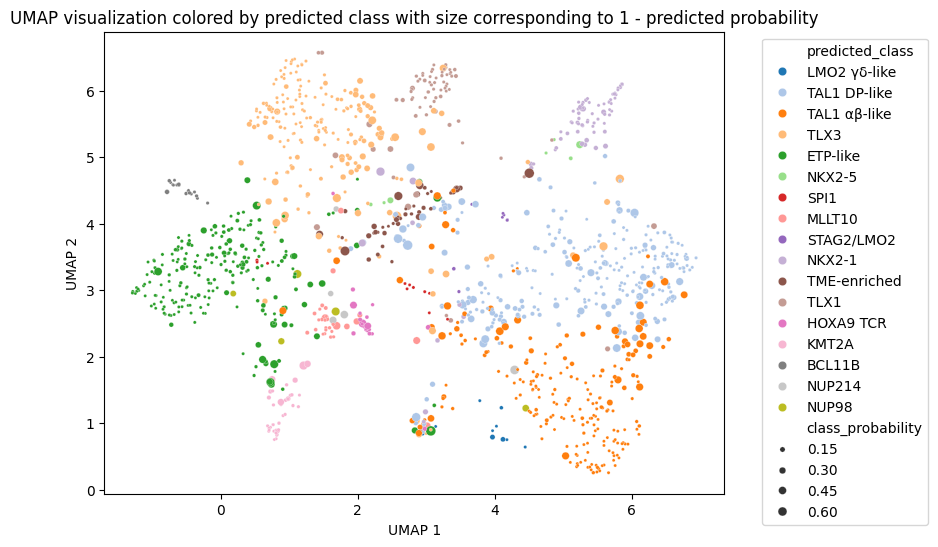

In [152]:
new = probs.idxmax(axis=1).str.split('_', n=1, expand=True)[[1]].join(probs.max(axis=1).rename('2'))
new.columns = ['predicted_class', 'class_probability']
#create umap plot with size of points corresponding to predicted probability of the predicted class
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=umap[:, 0],
    y=umap[:, 1],
    hue=new['predicted_class'],
    size=1-new['class_probability'],
    sizes=(5, 50),   # min and max marker sizes for mapping
    palette='tab20',
    legend='brief', 
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP visualization colored by predicted class with size corresponding to 1 - predicted probability')
plt.show()

❓Why are the performance metrics that high?

## Risk Prediction

Next we'll look at the risk modeling outputs:
- these are risk coefficents
- higher coefficent means higher risk
- if we know baseline risk and have survival times we could translate them to time-to-event

In [41]:
#eta = pd.read_csv(result[0][2], sep='\t', index_col=0) # change to eta.tsv
eta = pd.read_csv('eta.tsv', sep='\t', index_col=0)
eta.head()

,eta_cause_Relapse,eta_cause_Toxic Death,eta_cause_Induction failure,eta_cause_Second Malignant Neoplasm,eta_cause_Death NOS
PAUCKE,-0.854277,-5.157427,-2.094943,9.764708,-16.551990
PARLHD,-0.348798,-6.181395,-15.993982,10.738533,-17.035143
PARMJA,0.594366,-5.501553,-9.794559,9.419699,-3.888605
PARVRF,1.846782,-3.249362,-6.347599,-1.198192,-6.177755
PARYMD,-1.171677,-9.419189,-7.237601,-0.572066,-9.231157


Previously we defined some threshold/cutoffs for patients at high risk

In [42]:
# Reference Thresholds:
t_Relapse	= -0.7762965329213484	
t_Toxic_Death	= 1.4212229743071156
t_Induction_failure = 1.6236007775280876
t_Second_Malignant_Neoplasm = 13.75514348913861
t_Death_NOS = -2.5563675062921263
thresholds = {
    'Relapse': t_Relapse,
    'Toxic_Death': t_Toxic_Death,
    'Induction_failure': t_Induction_failure,
    'Second_Malignant_Neoplasm': t_Second_Malignant_Neoplasm,
    'Death_NOS': t_Death_NOS
}
at_risk = {}
for event_col, threshold in zip(eta.columns, thresholds.values()):
    samples_at_risk = eta[event_col] > threshold
    at_risk[event_col] = samples_at_risk[samples_at_risk.eq(True)].index.tolist()
    print(f"Samples at risk for {event_col}: {samples_at_risk.sum()} out of {len(eta)}")

Samples at risk for eta_cause_Relapse: 120 out of 1335
Samples at risk for eta_cause_Toxic Death: 26 out of 1335
Samples at risk for eta_cause_Induction failure: 38 out of 1335
Samples at risk for eta_cause_Second Malignant Neoplasm: 22 out of 1335
Samples at risk for eta_cause_Death NOS: 11 out of 1335


In [78]:
print(at_risk.get('eta_cause_Death NOS'))

['PARNEH', 'PASGUX', 'PATDTN', 'PAUSDP', 'PAVPYX', 'PAVVIL', 'PAVWZZ', 'PAVXPD', 'PAWAIN', 'PAWBTV', 'PAWKUU']


### Visualisation of Risk Scores via a Heatmap

C:\Users\stoib\AppData\Local\Temp\ipykernel_25268\2074457185.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_subtypes_list))


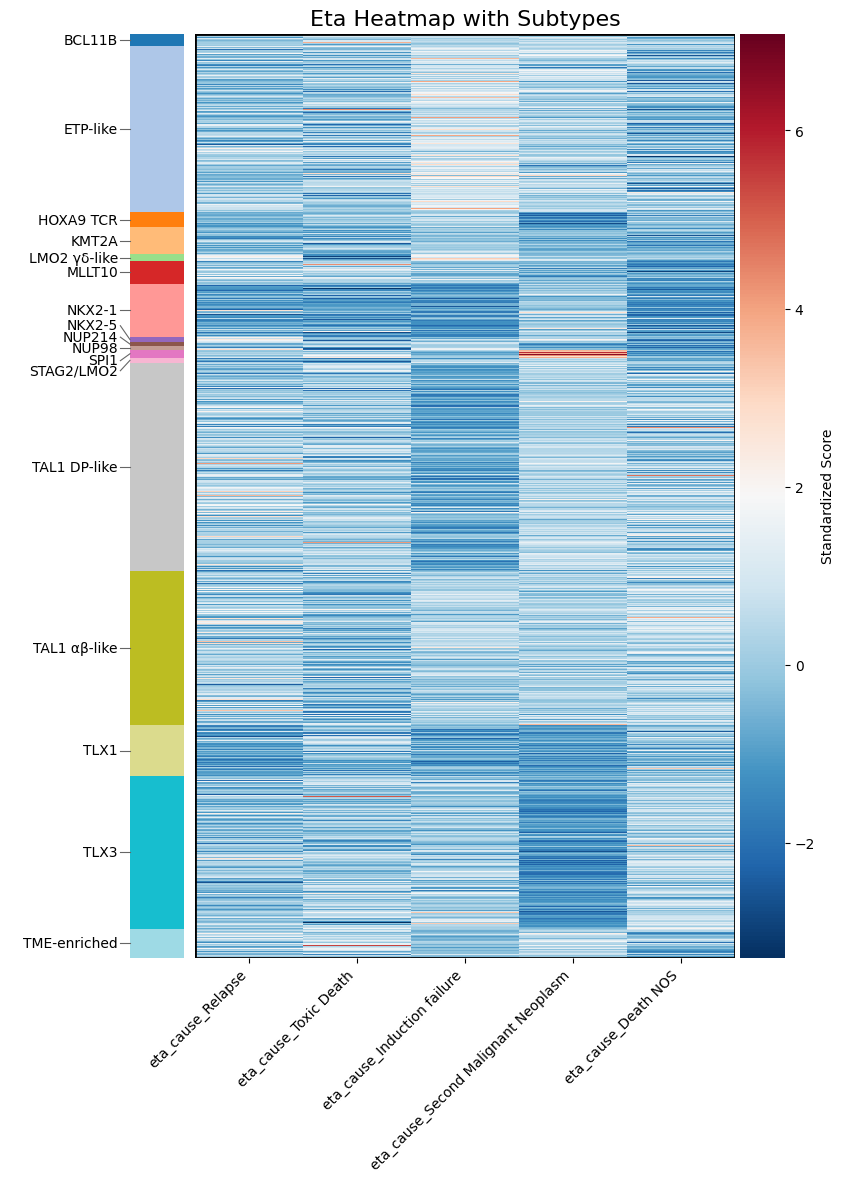

In [ ]:
# Create a standalone heatmap figure from eta and labels data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Prepare the data
# We use the 'eta' DataFrame for the heatmap and 'labels' for the subtypes.
# First, we need to align them.
data_for_heatmap = eta.join(labels)
data_for_heatmap = data_for_heatmap.rename(columns={'Reviewed.subtype': 'Predicted Subtype'})

# Sort by subtype for grouped visualization
data_sorted = data_for_heatmap.sort_values('Predicted Subtype')
subtypes = data_sorted['Predicted Subtype']
heatmap_data = data_sorted.drop(columns=['Predicted Subtype'])

# Normalize the heatmap data
scaler = StandardScaler()
heatmap_normalized = pd.DataFrame(
    scaler.fit_transform(heatmap_data),
    index=heatmap_data.index,
    columns=heatmap_data.columns
)

# 2. Create the figure and axes
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 3, 0.25], wspace=0.02)
ax_cbar = fig.add_subplot(gs[0])      # left: colored bar + legend lines
ax_heat = fig.add_subplot(gs[1])      # middle: heatmap
ax_heat_cbar = fig.add_subplot(gs[2]) # right: heatmap colorbar

# 3. LEFT: vertical color strip per sample
ax_cbar.set_xlim(-0.5, 1.0)
ax_cbar.set_ylim(0, len(subtypes))
ax_cbar.axis('off')

# Create a color mapping for subtypes if it doesn't exist
if 'subtype_colors' not in locals():
    unique_subtypes_list = sorted(subtypes.unique())
    colors = plt.cm.get_cmap('tab20', len(unique_subtypes_list))
    subtype_colors = {subtype: colors(i) for i, subtype in enumerate(unique_subtypes_list)}

rect_x = 0.5
rect_w = 0.45
for i, st in enumerate(subtypes):
    ax_cbar.add_patch(
        plt.Rectangle(
            (rect_x, i), rect_w, 1,
            color=subtype_colors.get(st, 'gray'), # Use gray for subtypes without a color
            ec='none',
            transform=ax_cbar.transData
        )
    )
ax_cbar.invert_yaxis()

# 4. Add legend labels and connector lines
unique_subtypes = pd.Index(subtypes).unique()
subtype_positions = {}
for st in unique_subtypes:
    idxs = np.where(subtypes.values == st)[0]
    if len(idxs) > 0:
        subtype_positions[st] = idxs.mean() + 0.5

label_x = rect_x - 0.1
subtype_label_offsets = {
    'NKX2-5': -20.0,  # move up
    'NUP214': -10.0,  # move up
    'STAG2/LMO2': 15.0,  # move down
    'SPI1': 10.0     # move down

}
for st, y in subtype_positions.items():
    # Apply offset if defined for this subtype
    label_y = y + subtype_label_offsets.get(st, 0)
    #print(f"Label: {st}, Original Y: {y:.2f}, Label Y: {label_y:.2f}")
    ax_cbar.plot(
        [rect_x, label_x + 0.02], [y, label_y],
        color='0.4',
        linewidth=0.8,
        transform=ax_cbar.transData,
        zorder=1
    )
    ax_cbar.text(
        label_x, label_y, st,
        ha='right',
        va='center',
        fontsize=10,
        transform=ax_cbar.transData
    )

# 5. MIDDLE: heatmap
sns.heatmap(
    heatmap_normalized,
    annot=False,
    cmap='RdBu_r',
    linewidths=0,
    cbar_kws={'label': 'Standardized Score'},
    ax=ax_heat,
    cbar_ax=ax_heat_cbar
)
ax_heat.set_xticklabels(ax_heat.get_xticklabels(), rotation=45, ha='right')
ax_heat.set_yticks([])
ax_heat.set_title('Eta Heatmap with Subtypes', fontsize=16)

# Add a border around the heatmap
border = patches.Rectangle((0, 0), len(heatmap_data.columns), len(heatmap_data.index),
                            linewidth=2, edgecolor='black', facecolor='none')
ax_heat.add_patch(border)

plt.show()

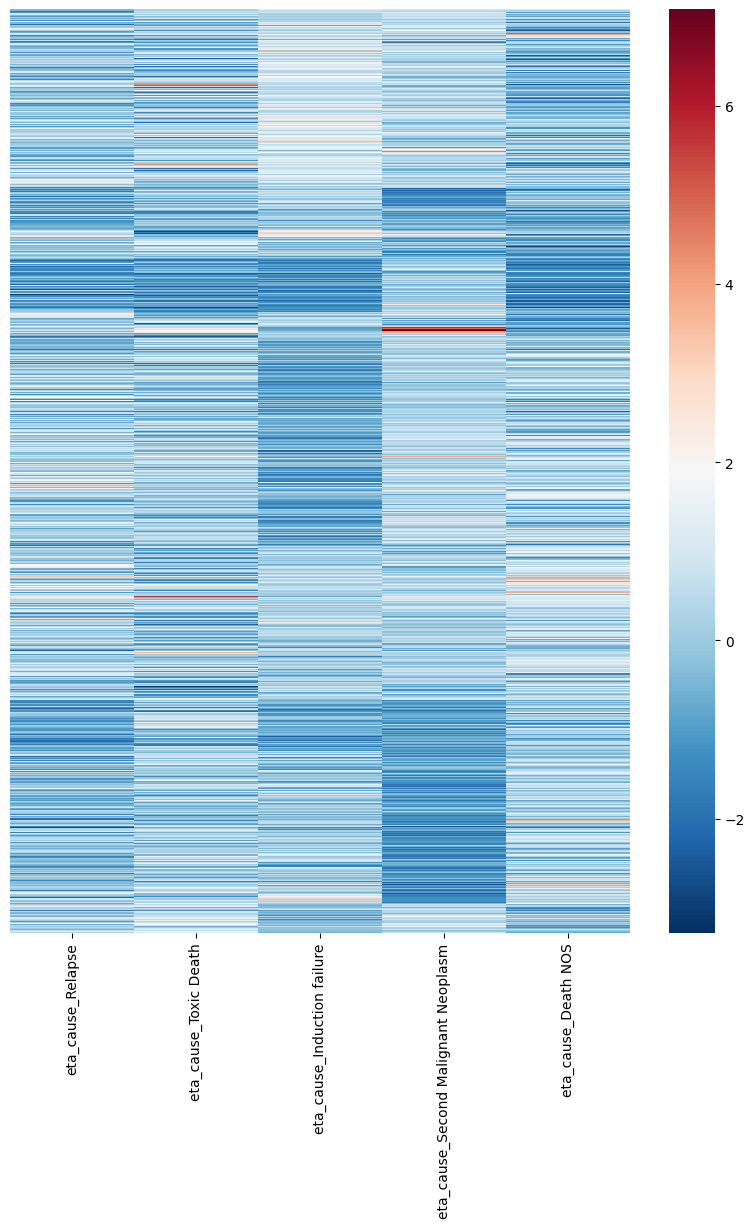

In [56]:
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    heatmap_normalized,
    annot=False,
    cmap='RdBu_r',
    linewidths=0,
    ax=ax,
)
# Documentation for sns.heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax.set_yticks([])
plt.show()

### Visualisation of Risk in a UMAP

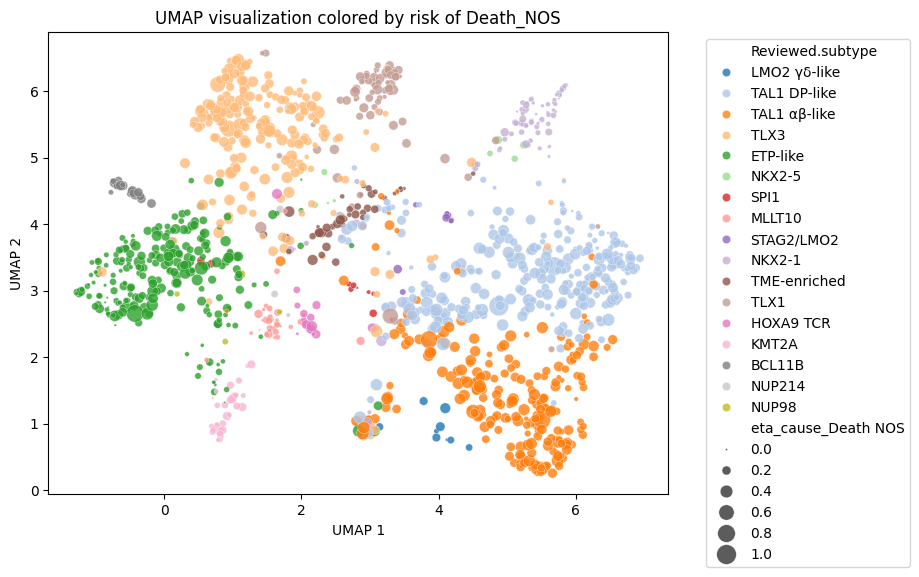

In [ ]:
# Plot a UMAP with samples colored by risk of certain event, using the same UMAP coordinates as before
import matplotlib.pyplot as plt
event = 'Death_NOS'  # Change this to the event you want to visualize
event_map = {'Relapse': "eta_cause_Relapse" ,
             'Toxic_Death': "eta_cause_Toxic Death",
             'Induction_failure': "eta_cause_Induction failure",
             'Second_Malignant_Neoplasm': "eta_cause_Second Malignant Neoplasm",
             'Death_NOS': "eta_cause_Death NOS"}
plt.figure(figsize=(8, 6))

# compute numeric sizes, align index with labels
sizes_raw = eta[event_map[event]] - eta[event_map[event]].min()

# normalize to 0..1
sizes_norm = (sizes_raw - sizes_raw.min()) / (sizes_raw.max() - sizes_raw.min())


# exaggerate differences: use a power (>1) and scale to a large range
sizes = (sizes_norm ** 2) #* 1500 + 10  # change power and multiplier to make contrast stronger

sns.scatterplot(
    x=umap[:, 0],
    y=umap[:, 1],
    hue=labels['Reviewed.subtype'],
    size=sizes,
    sizes=(2, 200),   # min and max marker sizes for mapping
    palette='tab20',
    legend='brief',
    alpha=0.8
)

# Documentation for sns.scatterplot: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'UMAP visualization colored by risk of {event}')
plt.show()
